https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

In [1]:
import re
import string
import random
import torch as t
import torch.nn as nn
from torch.distributions import Normal
from functools import reduce
import numpy as np

In [2]:
def P(trace):
    a = WrappedDist(Normal, t.ones(2), 3)
    b = WrappedDist(Normal, t.ones(2), 3)
    #return (a+b)

"""
class Q(nn.Module):
    def __init__(self) :
        self.Kw

    # TMC version
    # z = q.sample
    # elbo = p.log_prob(x, z) - q.log_prob(z)
    # average with logmeanexp(elbo)
    def forward(self, x):
        w  = q.Qw().sample(sample_shape=t.Size([self.Kw, 1, 1]))
        z  = q.Qz().sample(sample_shape=t.Size([self.Kz, x.size(0)]))

        fw = p.Pw().log_prob(w) - q.Qw().log_prob(w)
        fz = p.PzGw(w).log_prob(z) - q.Qz().log_prob(z)
        fx = p.PxGz(z).log_prob(x)

        f_int_z = u.logmeanexp(fz + fx, -2)
        f_int_z = f_int_z.sum(-1) + fw.view(-1)
        f_int_w = u.logmeanexp(f_int_z)

        return f_int_w
"""


class Q(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can't be negative, hence log var
        sigma = t.exp(0.5 * log_var) + 1e-5
        eps = t.randn_like(sigma)
        
        return mu + sigma * eps

    # samples from Q
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        noised = self.reparameterize(mu, log_var)
        
        return noised, mu, log_var



def ll_gaussian(y, mu, log_var):
    sigma = t.exp(0.5 * log_var)
    return -0.5 * t.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2


def elbo(y_pred, y, mu, log_var):
    # likelihood of y given q mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, t.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    return (likelihood + log_prior - log_p_q).mean()


def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)


# analytic soln for Gaussian
def det_loss(y, y_pred, mu, log_var):    
    reconstruction_error = (0.5 * (y - y_pred)**2) \
                            .sum()
    distance = 1 + log_var - mu**2 - log_var.exp()
    kl_divergence = (-0.5 * t.sum(distance))

    return (reconstruction_error + kl_divergence) \
            .sum()

In [3]:
# from
# https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()
X = t.tensor(x, dtype=t.float)
Y = t.tensor(y, dtype=t.float)

In [4]:
epochs = 1500

m = Q()
optim = t.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

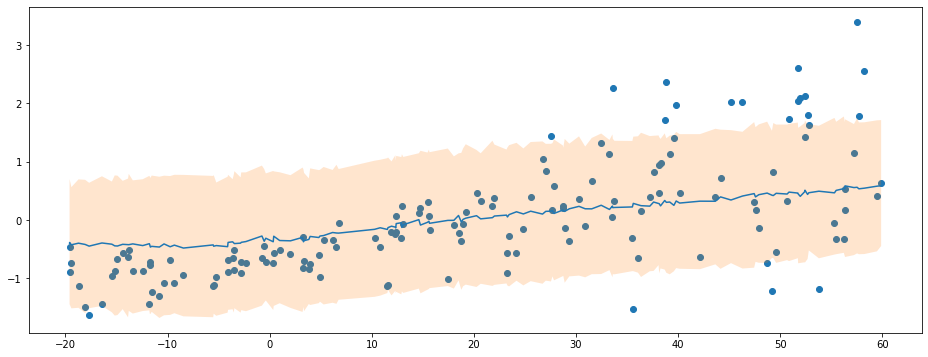

In [5]:
with t.no_grad():
    y_pred = t.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)


import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)